# Week 01
---
* Tokenizer 
* Padding
* Unique Word 
* Ovv Token

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer # Convert Sentence To Vector
from tensorflow.keras.preprocessing.sequence import pad_sequences # Fill Zeros In Long Sentences

sentences = [
    'I love my dog!', 
    'I love my cat',
    'Do you think my dog is amazing?'
]

In [15]:
# All punctuation and upper word convert to lower
tokenizer = Tokenizer(num_words=100, oov_token='<OOV>') # num_word - it's size of our dictionary  
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index # Word Index - Create Dictionary 
print(word_index)

{'<OOV>': 1, 'my': 2, 'i': 3, 'love': 4, 'dog': 5, 'cat': 6, 'do': 7, 'you': 8, 'think': 9, 'is': 10, 'amazing': 11}


In [16]:
# If we have sentences with different size 
# Convert to Int 
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[3, 4, 2, 5], [3, 4, 2, 6], [7, 8, 9, 2, 5, 10, 11]]


In [26]:
# Padding Fills Zeros To Same Lenght  
padded = pad_sequences(sequences)
print('Padding Before:')
print(padded)

# Fill Zeros After Text
padded = pad_sequences(sequences, padding='post')
print('\nPadding After:')
print(padded)

# Create Max Lenght
padded = pad_sequences(sequences, padding='post', maxlen=5)
print('\nPaddning Max Len=5:')
print(padded)

Padding Before:
[[ 0  0  0  3  4  2  5]
 [ 0  0  0  3  4  2  6]
 [ 7  8  9  2  5 10 11]]

Padding After:
[[ 3  4  2  5  0  0  0]
 [ 3  4  2  6  0  0  0]
 [ 7  8  9  2  5 10 11]]

Paddning Max Len=5:
[[ 3  4  2  5  0]
 [ 3  4  2  6  0]
 [ 9  2  5 10 11]]


In [27]:
# When we don't have text in main corpus dictionary
# Which word we don't have, replace to OOV_TOKEN
test_data = [
    'i really love my dog',
    'my dogs loves my manatee very much'
]
# Convert to Int 
test_seq = tokenizer.texts_to_sequences(test_data)
print('Int Sequences:')
print(test_seq)

test_pad = pad_sequences(test_seq)
print('\nPadding')
print(test_pad)

Int Sequences:
[[3, 1, 4, 2, 5], [2, 1, 1, 2, 1, 1, 1]]

Padding
[[0 0 3 1 4 2 5]
 [2 1 1 2 1 1 1]]


## Week 02 Word Embedding 

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Add Data In Two Arrays(Sentences and Labels)

In [13]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for text, label in train_data:
    training_sentences.append(str(text.numpy()))
    training_labels.append(label.numpy())
  
for text, label in test_data:
    testing_sentences.append(str(text.numpy()))
    testing_labels.append(label.numpy())


training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

**Make pre-processing of text**
* Tokenization -> Words in Number
* Word Index -> Dict Style, Word And Index 
* Text To Seq -> Arrays With Numbers
* Padding -> Fill Seq to Same Legnth 

In [14]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, 
                      oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)

padded = pad_sequences(sequences,
                       maxlen=max_length, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,
                               maxlen=max_length)

### Switch Word Index To Text

In [15]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

b'this was a wonderfully clever and entertaining movie that i shall never tire of watching many many times the casting was magnificent in matching up the young with the older characters there are those of us out here who really do appreciate good actors and an intelligent story format as for <OOV> <OOV> she is beautiful and a gift to any kind of production in which she stars i always make a point to see <OOV> <OOV> in all her performances she is a superb actress and a pleasure to watch as each transformation of her character comes to life i can only be grateful when i see such an outstanding picture for most of the motion pictures made more
b'This was a wonderfully clever and entertaining movie that I shall never tire of watching many, many times. The casting was magnificent in matching up the young with the older characters. There are those of us out here who really do appreciate good actors and an intelligent story format. As for Judi Dench, she is beautiful and a gift to any kind of

In [20]:
# Make a model With FlobalAverage1D faster, but accuracy shitty 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), #or Flatten() - more accuracy, but slower
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_epochs = 5
model.fit(padded, 
          training_labels, 
          epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels))

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 4s 162us/sample - loss: 0.5292 - accuracy: 0.7091 - val_loss: 0.3688 - val_accuracy: 0.8350
Epoch 2/5
25000/25000 [==============================] - 3s 129us/sample - loss: 0.2514 - accuracy: 0.9014 - val_loss: 0.3727 - val_accuracy: 0.8376
Epoch 3/5
25000/25000 [==============================] - 3s 127us/sample - loss: 0.0989 - accuracy: 0.9731 - val_loss: 0.4483 - val_accuracy: 0.8282
Epoch 4/5
25000/25000 [==============================] - 3s 127us/sample - loss: 0.0265 - accuracy: 0.9972 - val_loss: 0.5334 - val_accuracy: 0.8261
Epoch 5/5
25000/25000 [==============================] - 4s 152us/sample - loss: 0.0106 - accuracy: 0.9989 - val_loss: 0.5881 - val_accuracy: 0.8250


In [19]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


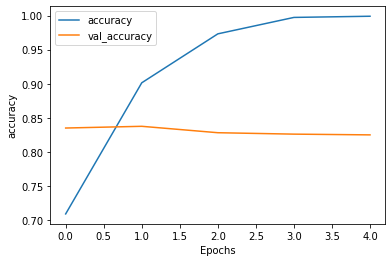

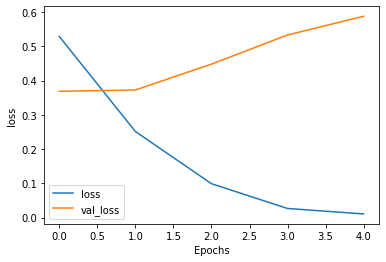

In [36]:
import matplotlib.pyplot as plt


def plot_graphs(model, string):
    plt.plot(model.history.history[string])
    plt.plot(model.history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  


plot_graphs(model, "accuracy")
plot_graphs(model, "loss")


This is for Visualisation Embeddings
https://projector.tensorflow.org

In [22]:
import io

out_v = io.open('visualisation/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('visualisation/meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()